In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [4]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mn = 0.602 # mass of N in lattice unit
mpi = 510/ainv # mass of pion in lattice unit

# import data

In [5]:
it0 = 12 # mainly use data at t/a = 12

In [6]:
ls ../data

Eeffs.pickle                       eigenfuncs_nn1s0_L48_t012.pkl
Meffs.pickle                       pot_H0term_jk_1s0_nn_L64_exp.pkl
Rcorr_jk_1s0_nn_L48.pkl            pot_H0term_jk_1s0_nn_L64_wall.pkl
dEeffs.pickle                      pot_jk_1s0_nn_L64_exp.pkl
eigenfuncs_nn1s0_L48_t011.pkl      pot_jk_1s0_nn_L64_wall.pkl


In [7]:
with open('../data/Rcorr_jk_1s0_nn_L48.pkl', 'rb') as fin:
    _, rs, Rcorr_jk = pickle.load(fin)

In [8]:
print(Rcorr_jk['wall'].keys())

dict_keys([10, 11, 12, 13, 14, 15, 16, 17])


In [9]:
for src in ['wall', 'exp']:
    Rcorr_jk[src] = Rcorr_jk[src][it0]

In [10]:
Rcorr_jk['wall'].shape

(20, 2925)

In [11]:
with open(f'../data/eigenfuncs_nn1s0_L48_t{it0:03d}.pkl', 'rb') as fin:
    vals, vecs, _ = pickle.load(fin)

In [12]:
vals.shape

(20, 2)

In [13]:
# >> convert to relativistic energy
conv_rela = lambda E: 2.0*np.sqrt(mn * E + mn**2) - 2.0*mn
vals = conv_rela(vals)

In [14]:
bin_num = vals.shape[0]

# check data

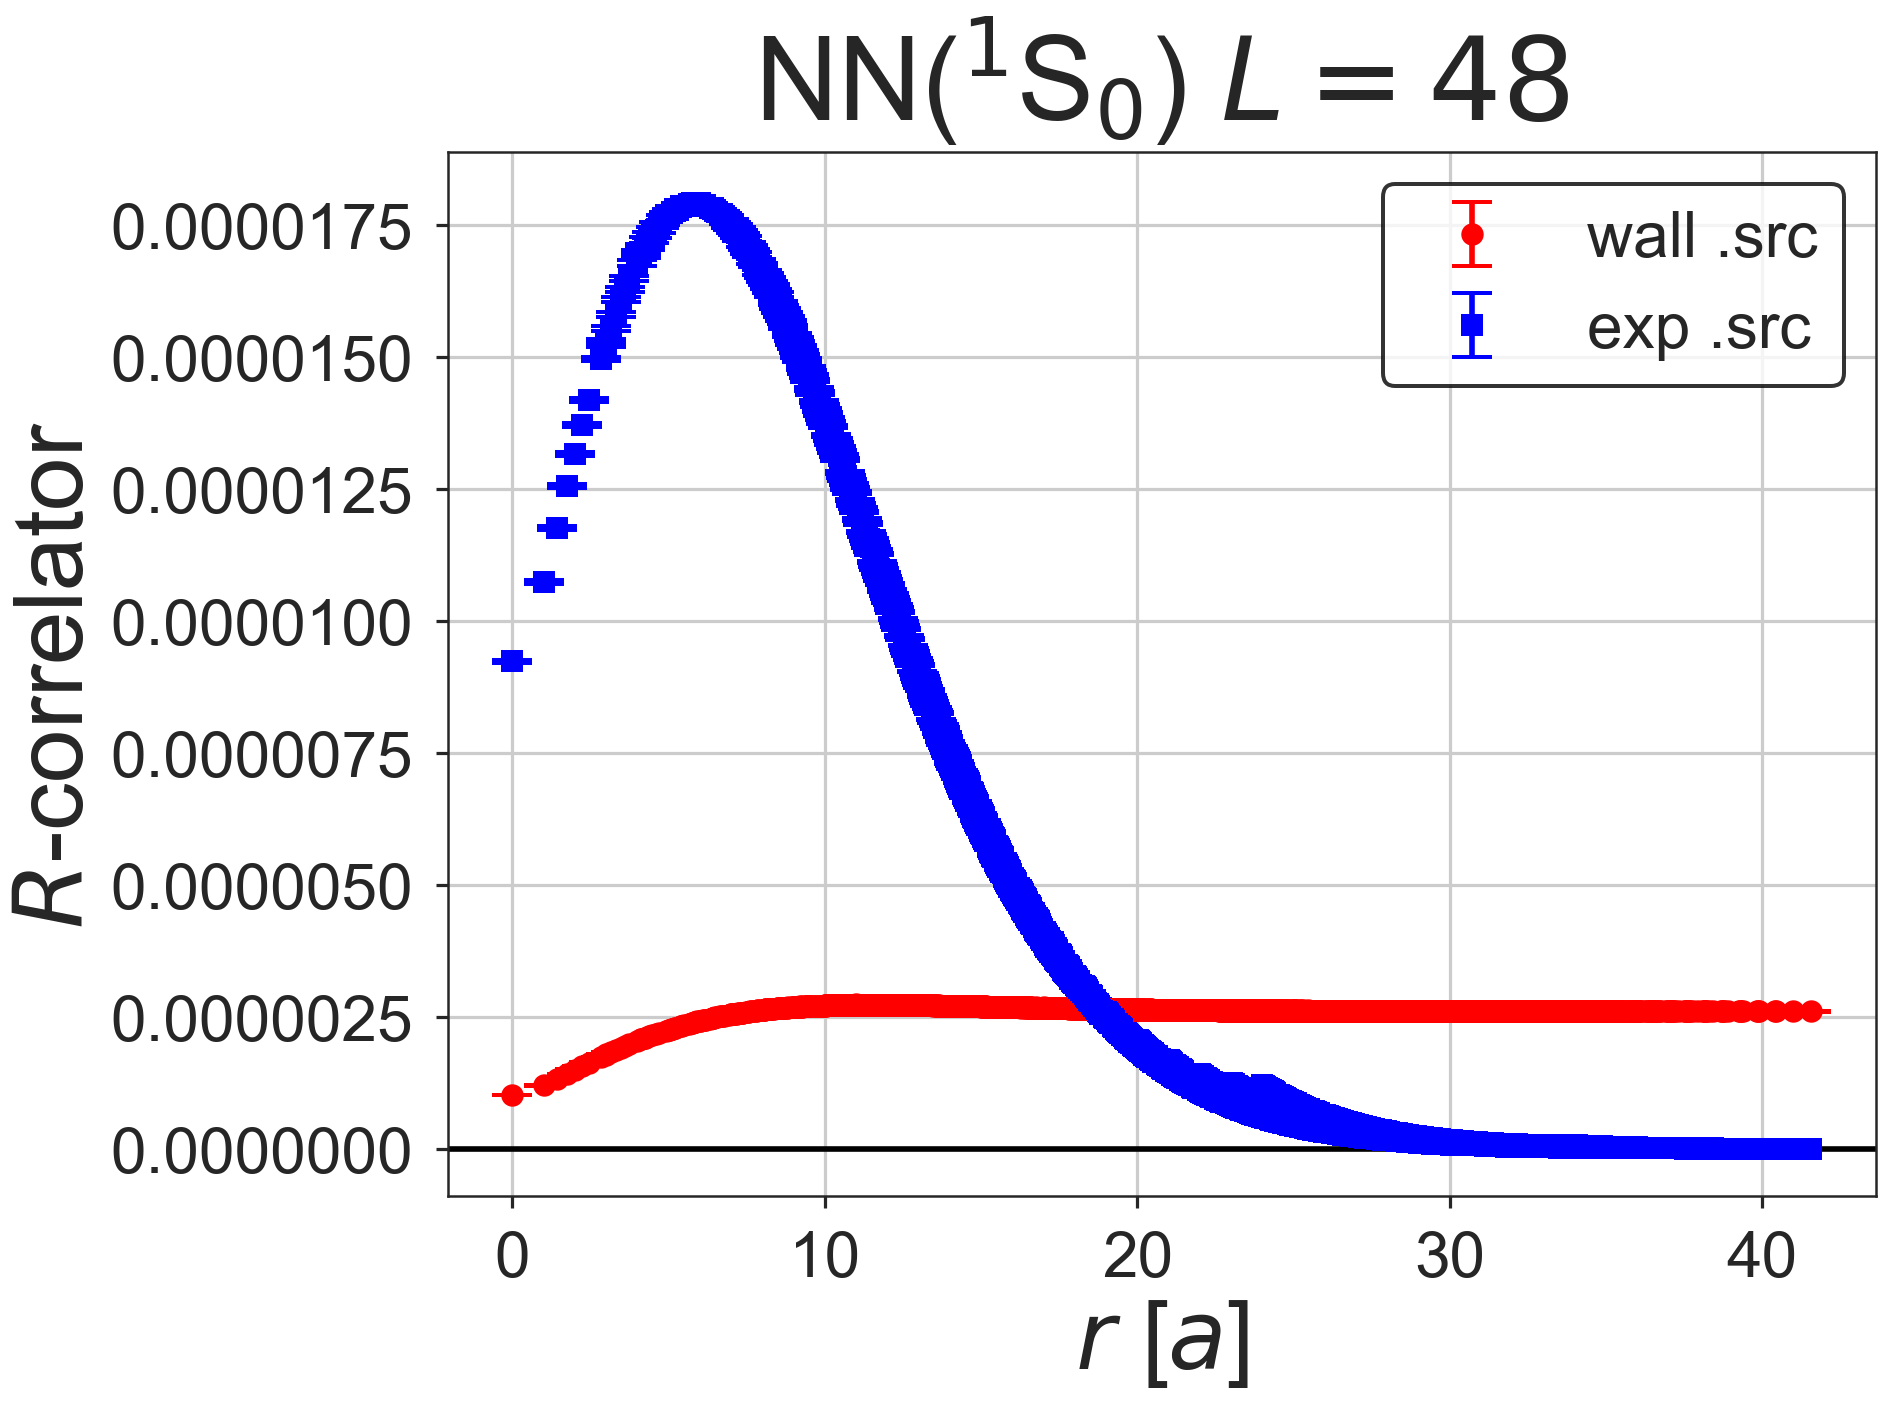

In [15]:
fig, ax = plt.subplots()

for src, fmt, col in zip(['wall', 'exp'], ['o', 's'], ['red', 'blue']):
    ax.errorbar(rs, Rcorr_jk[src].mean(axis=0),
           Rcorr_jk[src].std(axis=0) * np.sqrt(bin_num), fmt=fmt,
                label=src + ' .src', color=col, capthick=2.0, capsize=10)
    
ax.set_xlabel(r'$r$ [$a$]', size=48)
ax.set_ylabel(r'$R$-correlator', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.axhline(0, color='black')
ax.set_title(r'NN($^1$S$_0$) $L = 48$', size=58, y=1.02);

In [16]:
vecs.shape

(20, 2925, 2)

In [17]:
vals.shape

(20, 2)

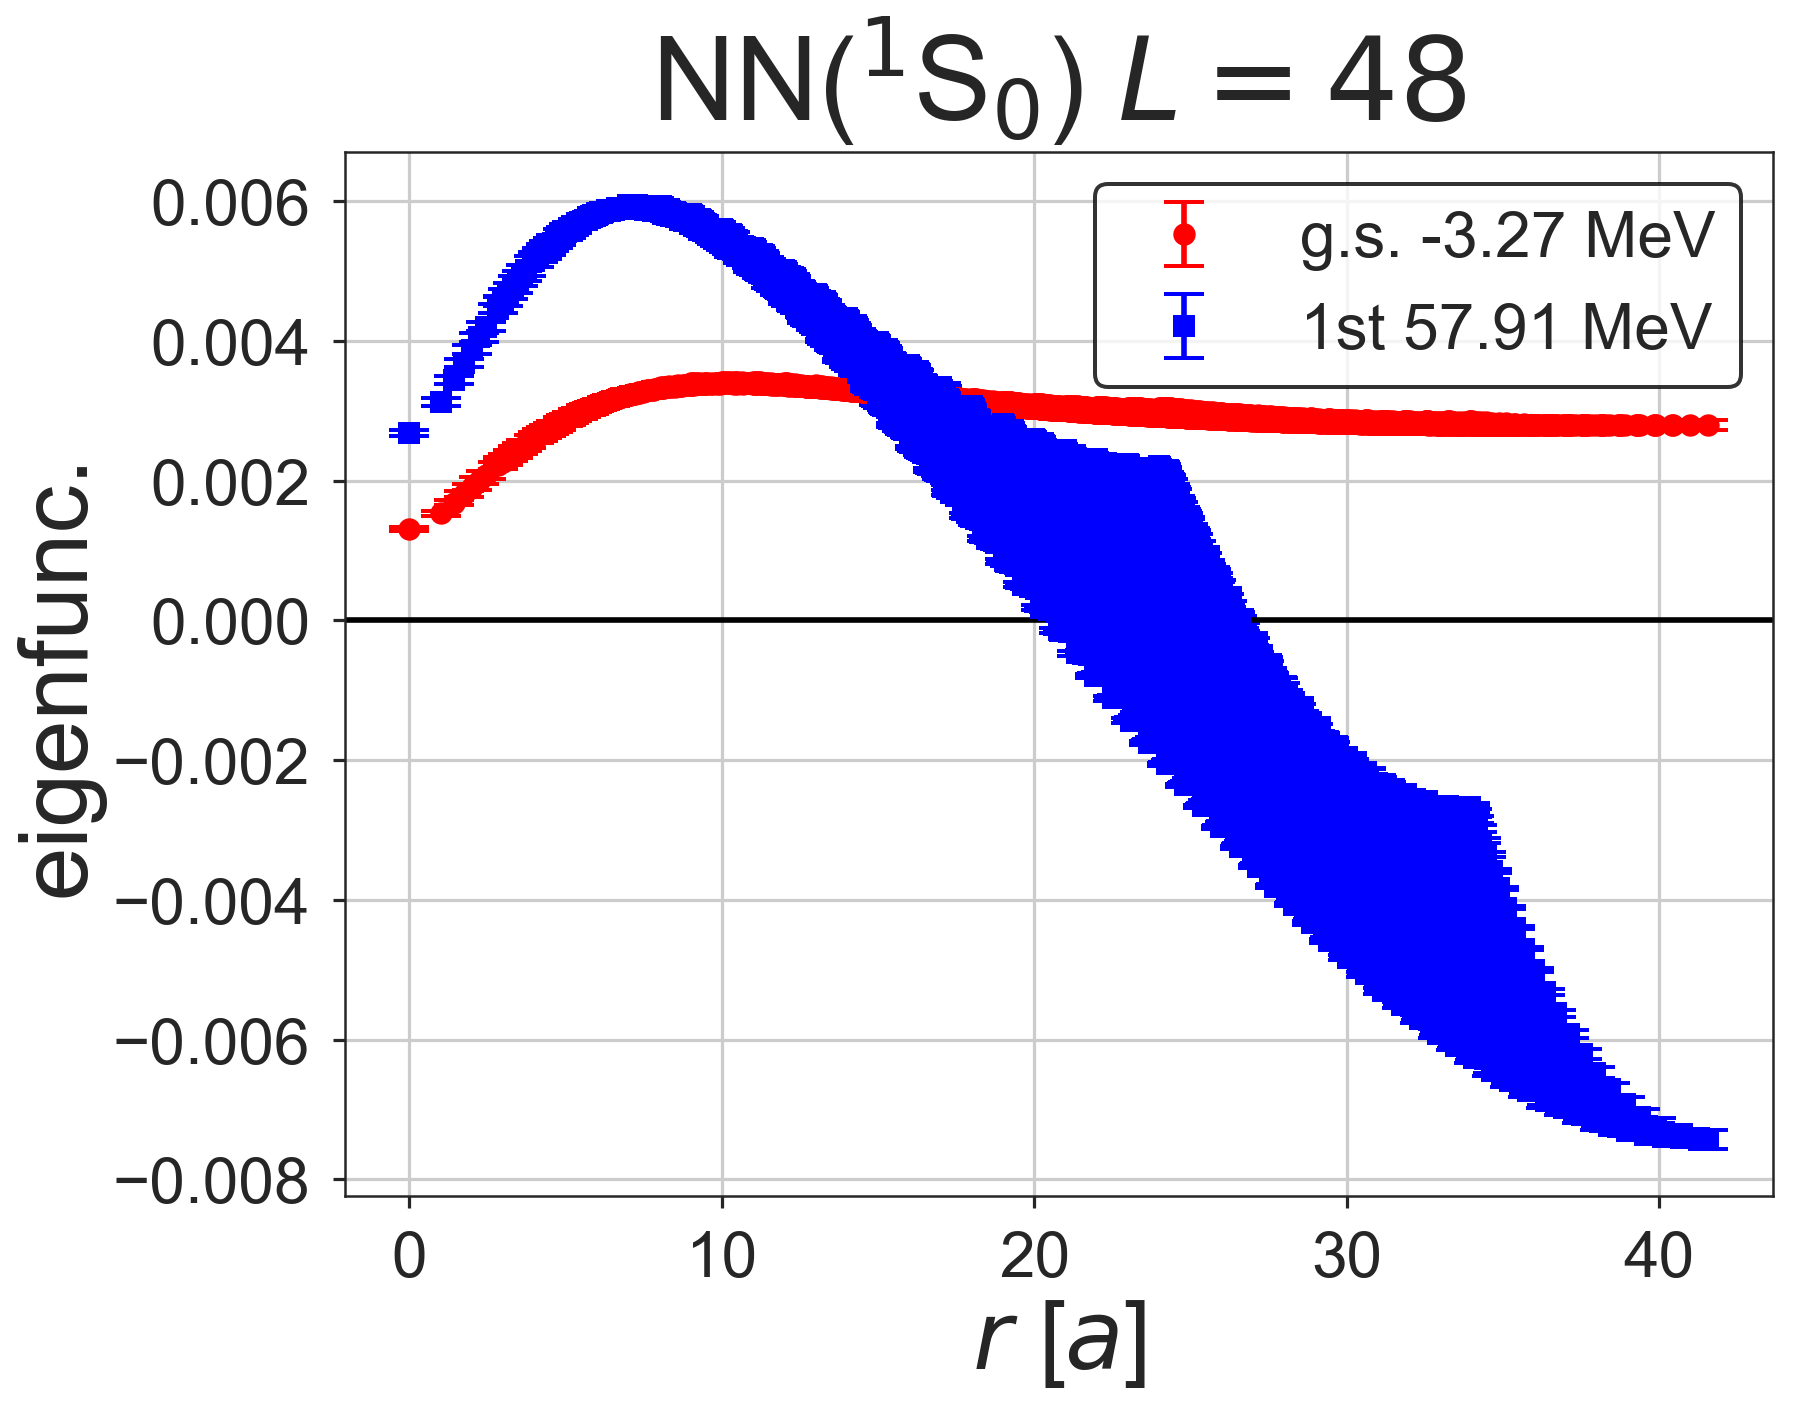

In [18]:
fig, ax = plt.subplots()

for ith, lbl, fmt, col in zip([0, 1], ['g.s.', '1st'], ['o', 's'], ['red', 'blue']):
    ax.errorbar(rs, vecs[:,:,ith].mean(axis=0),
           vecs[:,:,ith].std(axis=0) * np.sqrt(bin_num), fmt=fmt,
                label=lbl + r' {:3.2f} MeV'.format(vals[:,ith].mean()*ainv), color=col, capthick=2.0, capsize=10)
    
ax.set_xlabel(r'$r$ [$a$]', size=48)
ax.set_ylabel(r'eigenfunc.', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.axhline(0, color='black')
ax.set_title(r'NN($^1$S$_0$) $L = 48$', size=58, y=1.02);

# decompress data

In [19]:
L = 48
rs_full = np.array([np.sqrt(ix**2 + iy**2 + iz**2)
                    for ix in range(-L//2,L//2)
                    for iy in range(-L//2,L//2)
                    for iz in range(-L//2,L//2)]).reshape(L,L,L)
rs_full = np.roll(rs_full, (L//2,L//2,L//2), axis=(0,1,2)).flatten()


In [20]:
a1_uniq = np.array([ix + L * (iy + L * iz)
                   for ix in range(0, L//2+1)
                   for iy in range(0, ix+1)
                   for iz in range(0, iy+1)])

In [21]:
a1_uniq_ind = {}
ind = 0
for ix in range(0, L//2+1):
    for iy in range(0, ix+1):
        for iz in range(0, iy+1):
            a1_uniq_ind[(ix, iy, iz)] = ind
            ind += 1
xyz_ind = {}
for ix in range(L):
    for iy in range(L):
        for iz in range(L):
            _ind = np.sort([min(ix,L-ix), min(iy,L-iy), min(iz,L-iz)])[::-1]
            xyz_ind[(ix,iy,iz)] = a1_uniq_ind[(_ind[0], _ind[1], _ind[2])]

In [22]:
Rcorr_jk_full = {}
for src in ['wall', 'exp']:
    wave_full = np.zeros((bin_num, L, L, L))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz] = Rcorr_jk[src][:,xyz_ind[(ix,iy,iz)]]
    Rcorr_jk_full[src] = wave_full.reshape(bin_num, L**3)

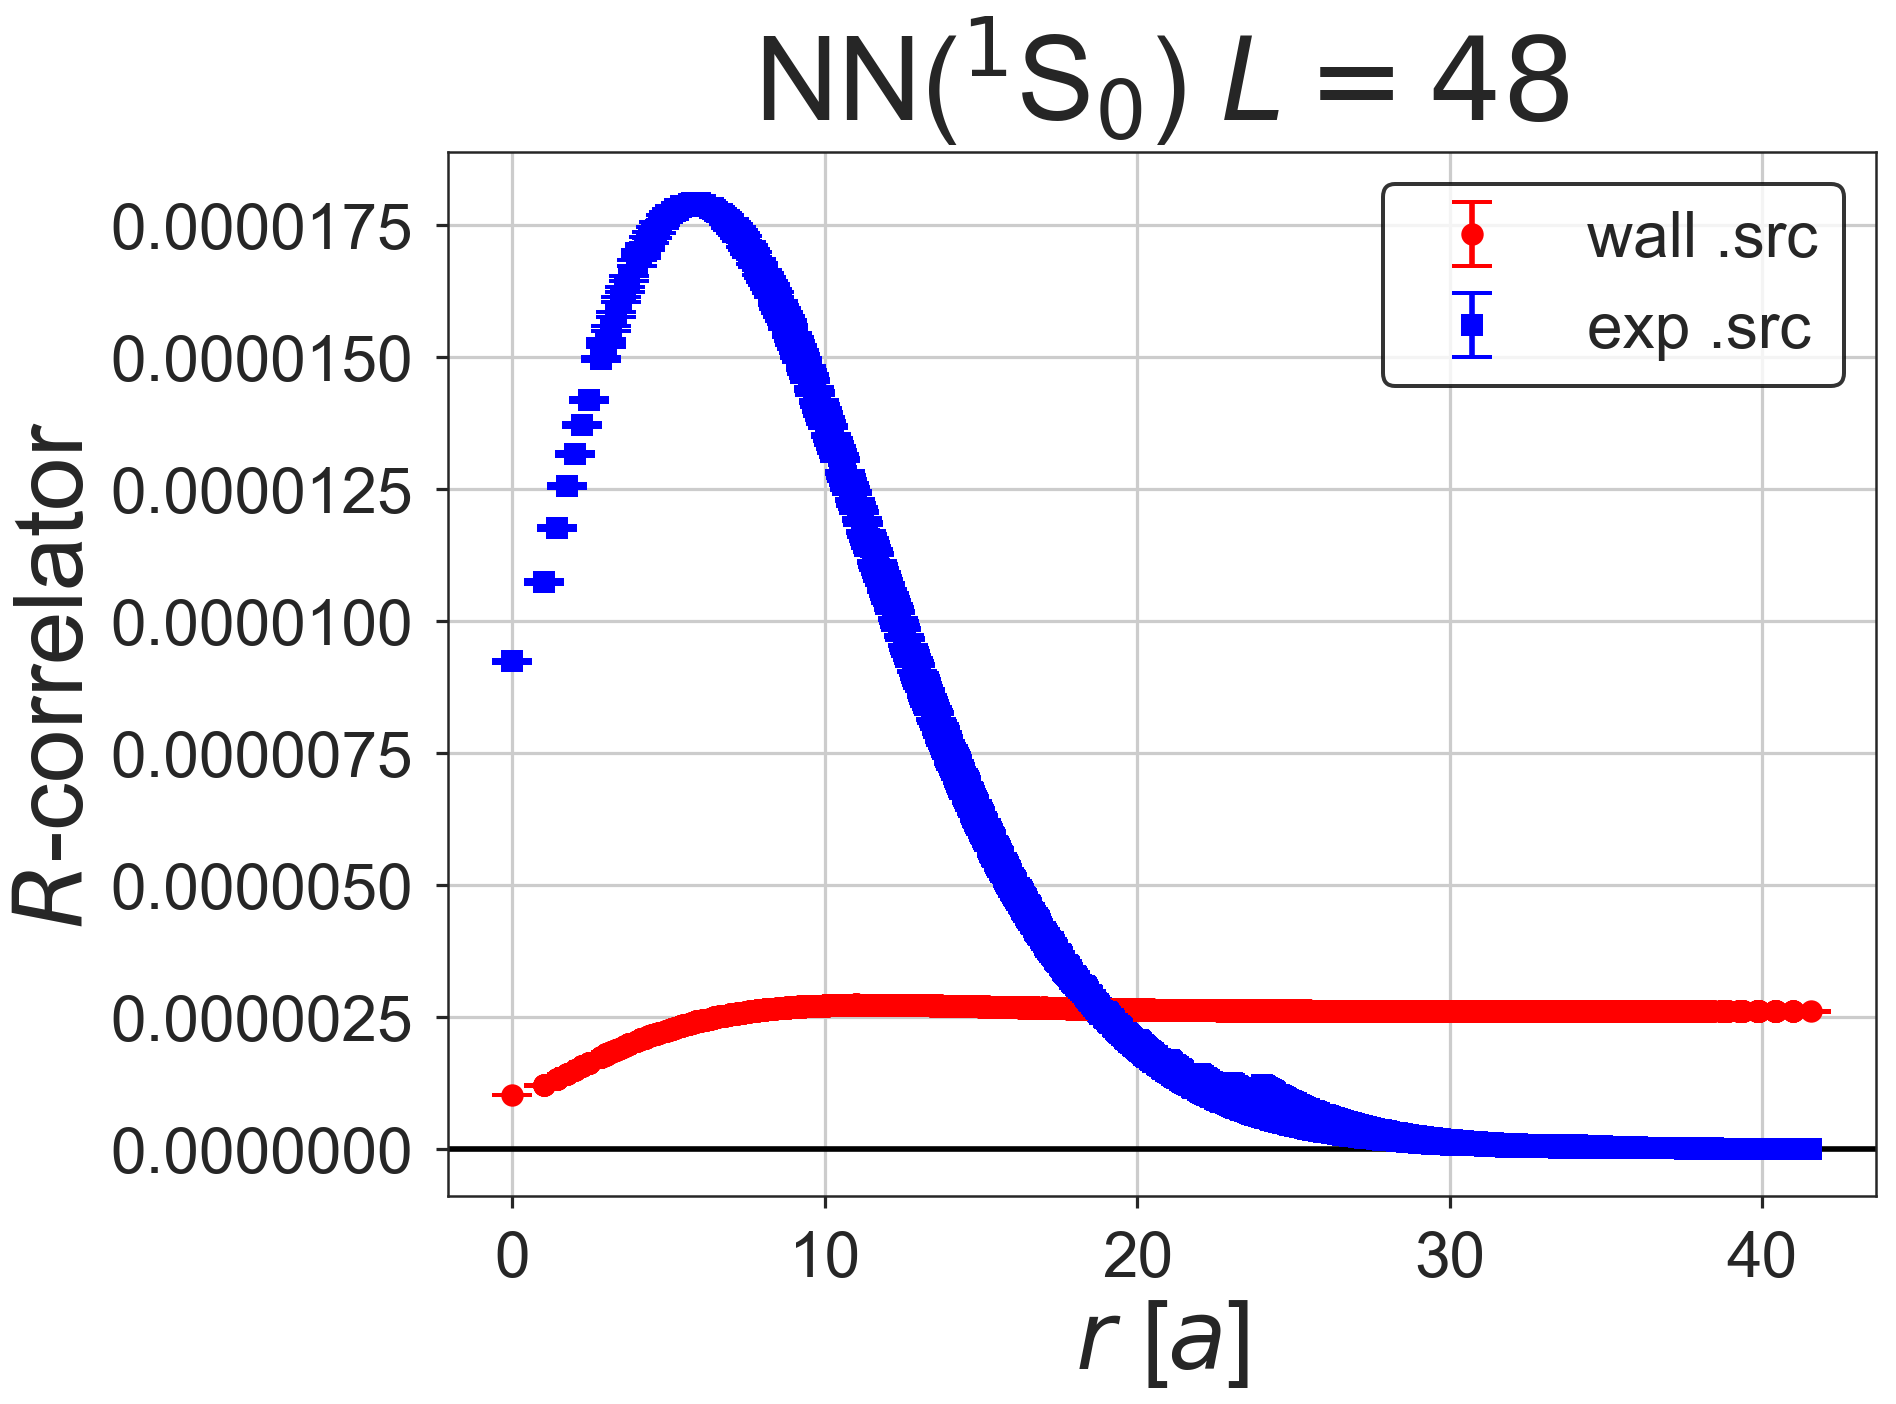

In [23]:
fig, ax = plt.subplots()

for src, fmt, col in zip(['wall', 'exp'], ['o', 's'], ['red', 'blue']):
    ax.errorbar(rs_full, Rcorr_jk_full[src].mean(axis=0),
           Rcorr_jk_full[src].std(axis=0) * np.sqrt(bin_num), fmt=fmt,
                label=src + ' .src', color=col, capthick=2.0, capsize=10)
    
ax.set_xlabel(r'$r$ [$a$]', size=48)
ax.set_ylabel(r'$R$-correlator', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.axhline(0, color='black')
ax.set_title(r'NN($^1$S$_0$) $L = 48$', size=58, y=1.02);

In [24]:
vecs.shape

(20, 2925, 2)

In [25]:
vecs_jk_full = {}
for level in [0, 1]:
    wave_full = np.zeros((bin_num, L, L, L))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz] = vecs[:,xyz_ind[(ix,iy,iz)], level]
    vecs_jk_full[level] = wave_full.reshape(bin_num, L**3)

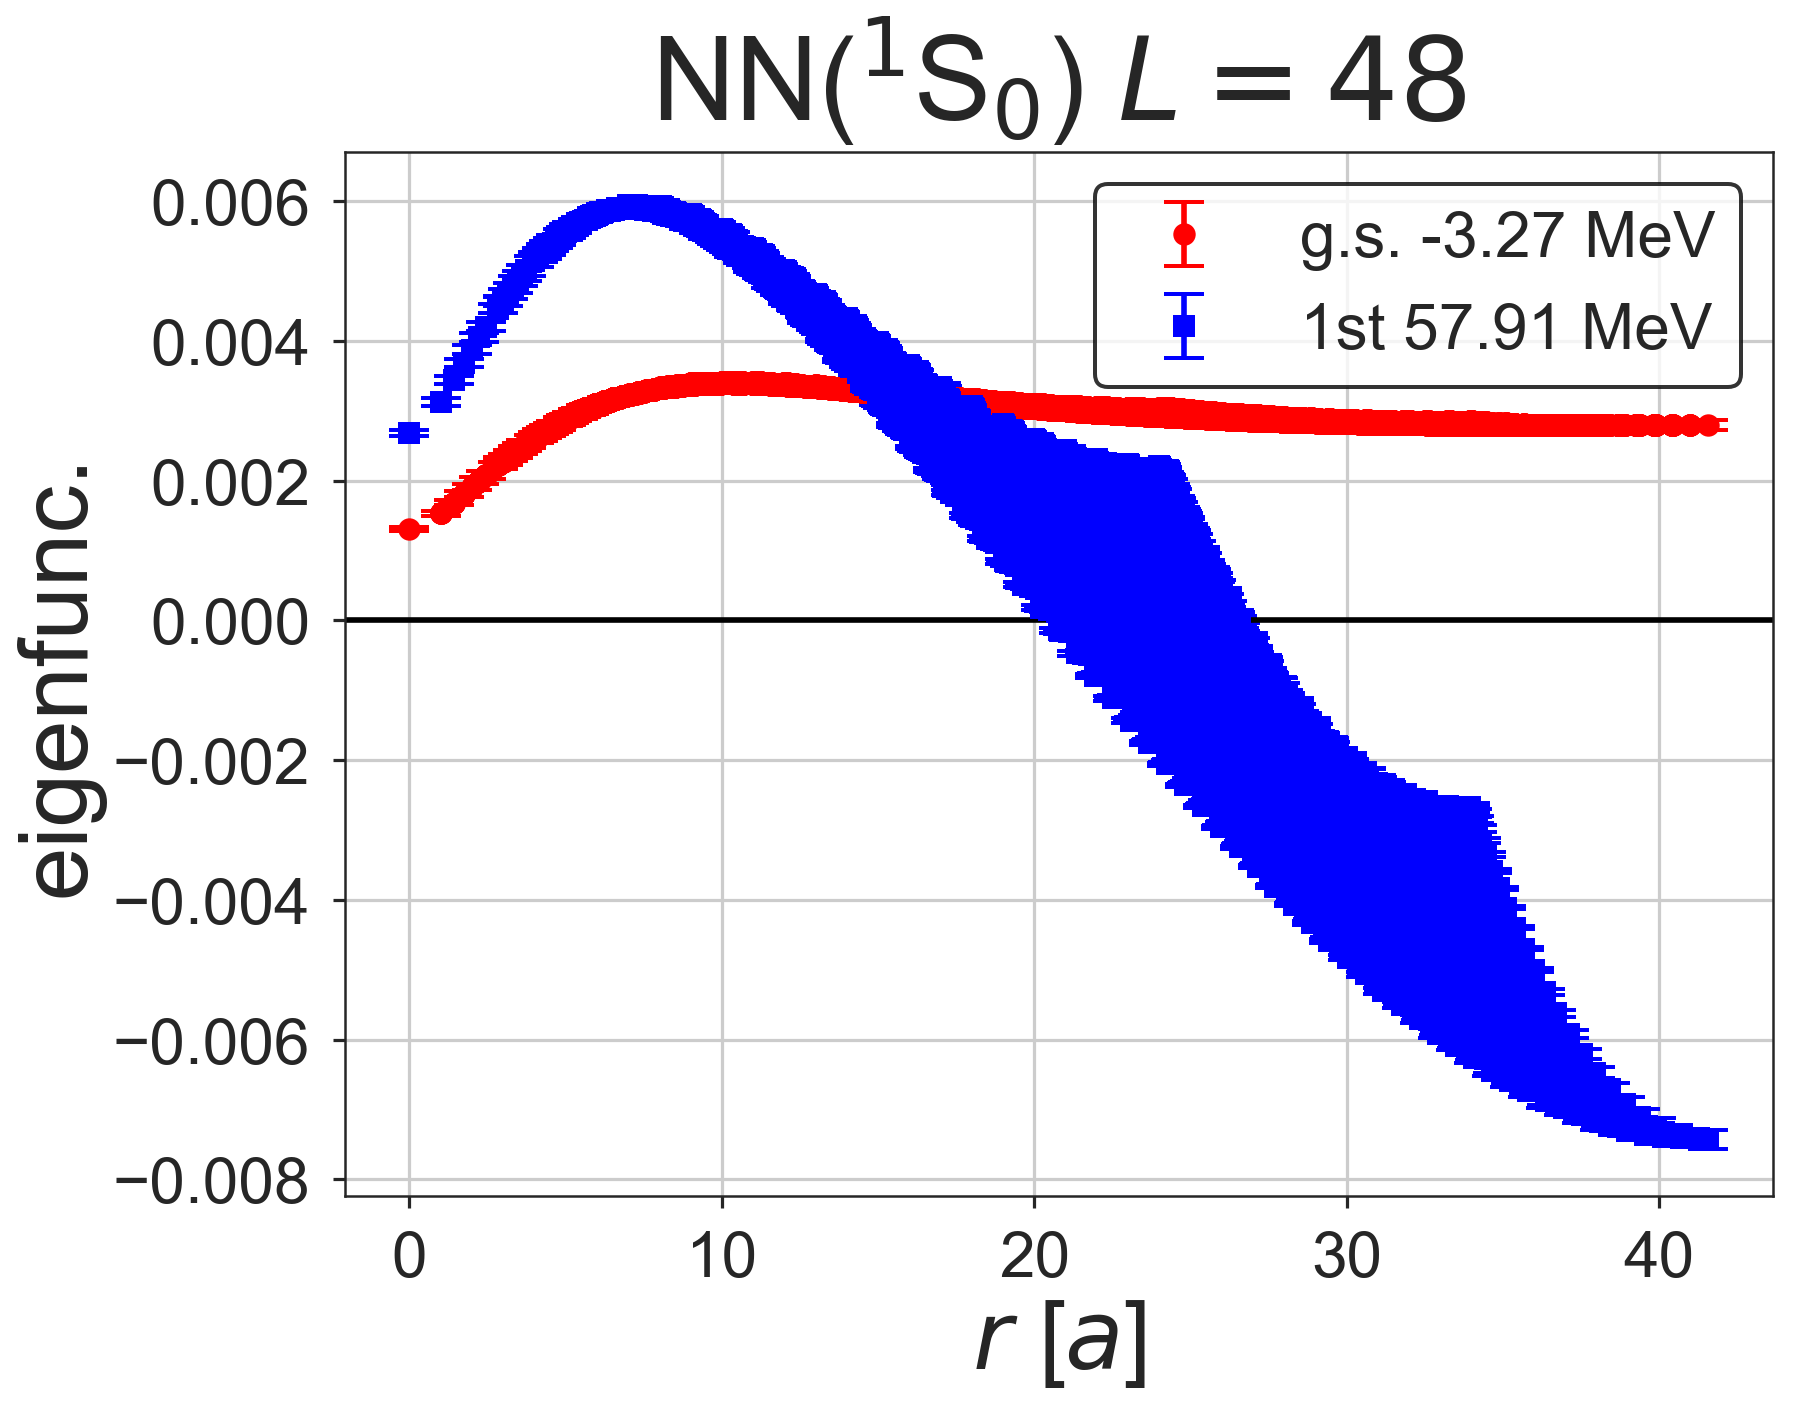

In [26]:
fig, ax = plt.subplots()

for ith, lbl, fmt, col in zip([0, 1], ['g.s.', '1st'], ['o', 's'], ['red', 'blue']):
    ax.errorbar(rs_full, vecs_jk_full[ith].mean(axis=0),
           vecs_jk_full[ith].std(axis=0) * np.sqrt(bin_num), fmt=fmt,
                label=lbl + r' {:3.2f} MeV'.format(vals[:,ith].mean()*ainv), color=col, capthick=2.0, capsize=10)
    
ax.set_xlabel(r'$r$ [$a$]', size=48)
ax.set_ylabel(r'eigenfunc.', size=48)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.axhline(0, color='black')
ax.set_title(r'NN($^1$S$_0$) $L = 48$', size=58, y=1.02);

In [27]:
Rcorr_jk_full['wall'].shape

(20, 110592)

In [28]:
vecs_jk_full[ith].shape

(20, 110592)

In [29]:
vals.shape

(20, 2)

In [30]:
def calc_contamination_factors(src):
    a_n_jk = []
    b_n_jk = []
    sum_psi_n_jk = []
    for nth in range(vals.shape[1]):
        _an = np.array([
            np.exp(vals[ibin,nth]*it0) * vecs_jk_full[nth][ibin,:].dot(Rcorr_jk_full[src][ibin,:])
            for ibin in range(bin_num)])
        
        a_n_jk.append(_an)
        _sum_psi = np.array([np.sum(vecs_jk_full[nth][ibin,:]) for ibin in range(bin_num)])
        b_n_jk.append(_an * _sum_psi)
        sum_psi_n_jk.append(_sum_psi)
    return np.array(a_n_jk), np.array(b_n_jk), np.array(sum_psi_n_jk)

an_jk = {}
bn_jk = {}
sum_psi_n_jk = {}
for src in ['wall', 'exp']:
    an_jk[src], bn_jk[src], sum_psi_n_jk[src] = calc_contamination_factors(src)

In [31]:
bn_jk['wall'].shape

(2, 20)

In [32]:
for src in ['wall', 'exp']:
    print(src + ' src.')
    _an = an_jk[src][1,:]/an_jk[src][0,:]
    print('a1/a0 = {:3.3f} +- {:3.3f}'.format(_an.mean(), _an.std() * np.sqrt(bin_num)))
    
    _bn = bn_jk[src][1,:]/bn_jk[src][0,:]
    print('b1/b0 = {:3.3f} +- {:3.3f}'.format(_bn.mean(), _bn.std() * np.sqrt(bin_num)))


wall src.
a1/a0 = -0.060 +- 0.012
b1/b0 = 0.003 +- 0.001
exp src.
a1/a0 = 1.558 +- 0.022
b1/b0 = -0.079 +- 0.013


# reconstruction

In [33]:
with open('../data/dEeffs.pickle', 'rb') as fin:
    _dEeffs = pickle.load(fin)

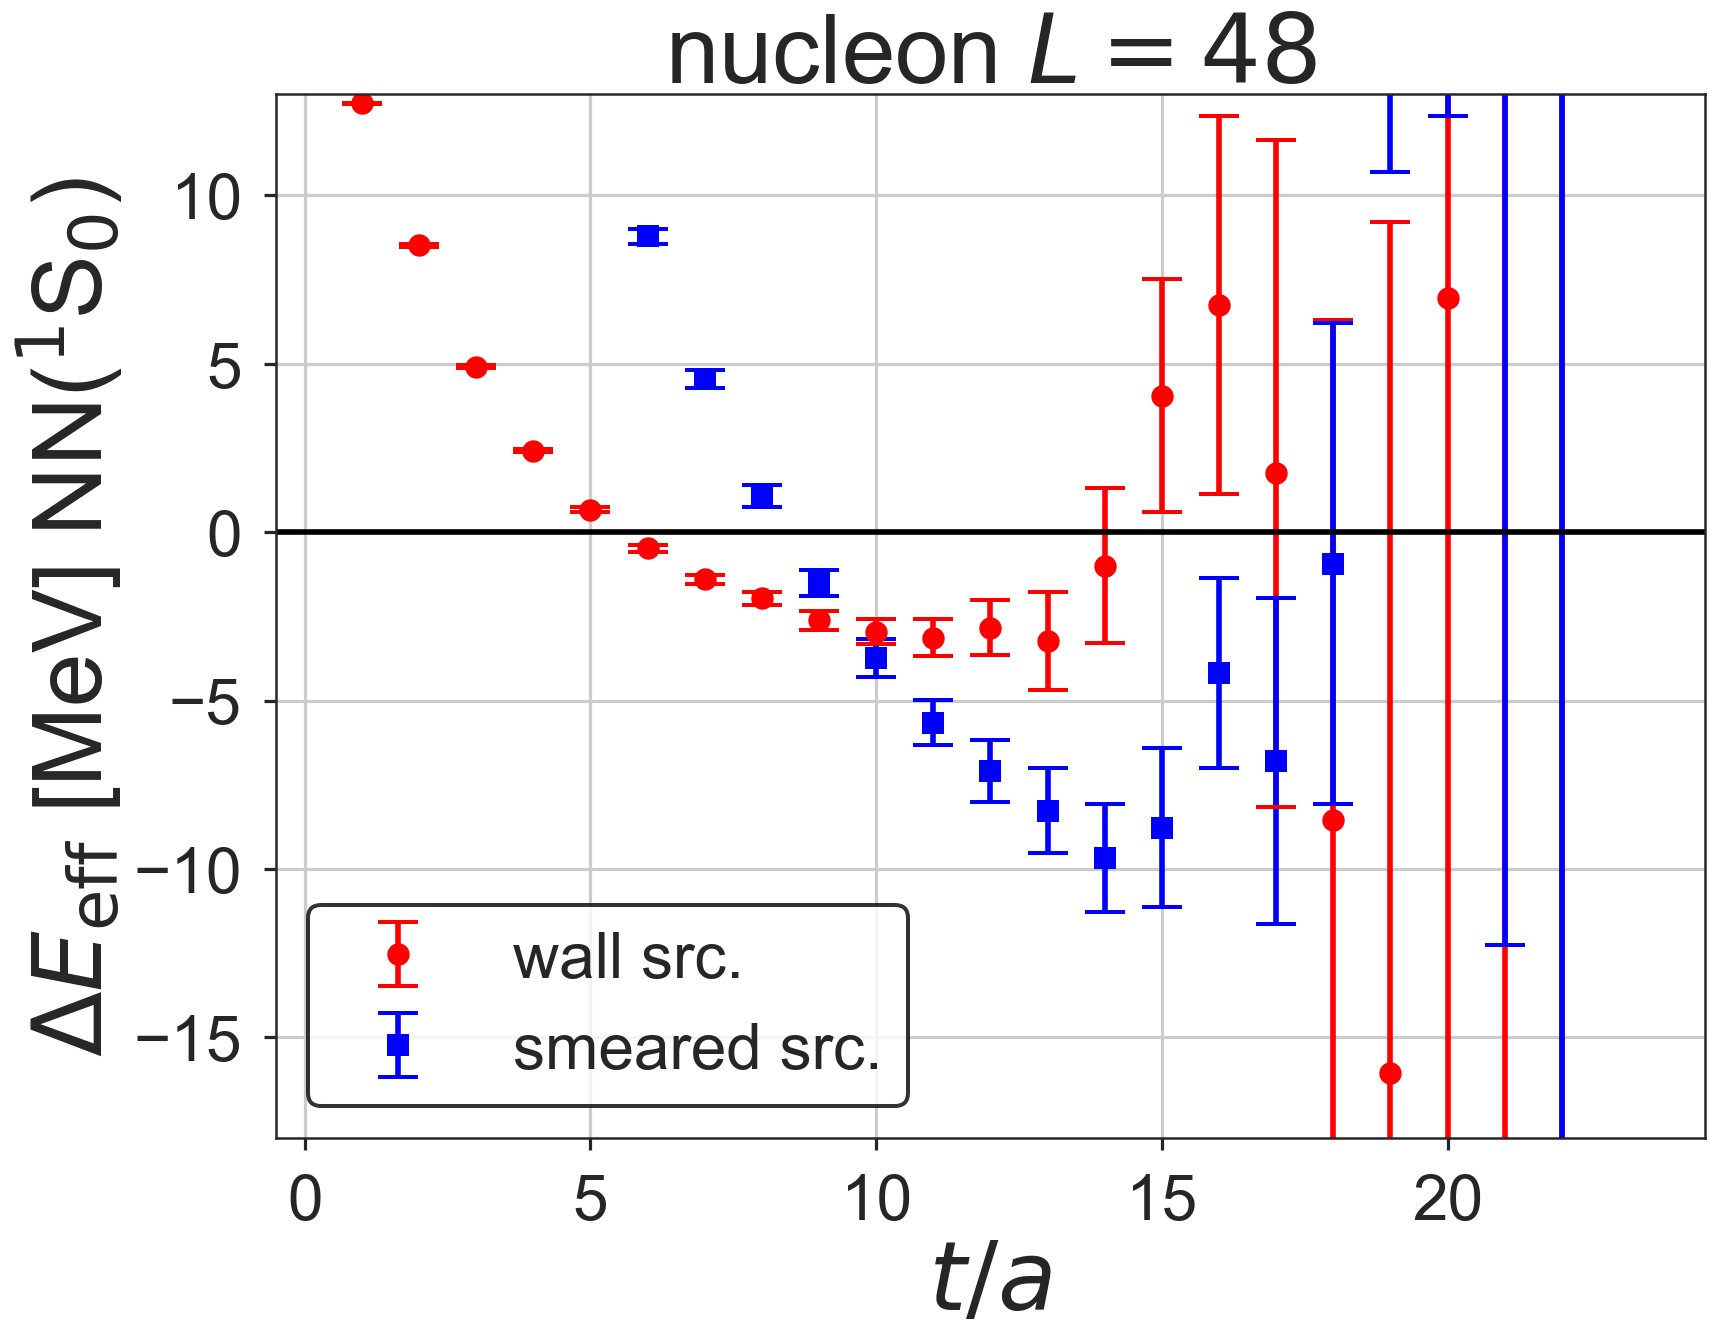

In [34]:
fig, ax = plt.subplots()
for src, fmt, col in zip(['wall', 'smeared'], ['o', 's'],
                         ['red', 'blue']):
    dEeff = _dEeffs[(48, src, 'rela', 'NN', '1S0')]
    ax.errorbar(dEeff[:,0], dEeff[:,3]*ainv, dEeff[:,4]*ainv, fmt=fmt,
                capsize=10, capthick=2, color=col,
               label=src + ' src.')
ax.set_ylim(-18, 13)
ax.set_xlim(-0.5, 24.5)
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_xlabel(r'$t/a$', size=48)
ax.set_ylabel(r'$\Delta E_\mathrm{eff}$ [MeV] NN($^1$S$_0$)', size=48)
ax.set_title('nucleon $L = 48$', size=48)
ax.axhline(0, color='black')

In [35]:
dEeffs = {}
dEeffs['wall'] = _dEeffs[(48, 'wall', 'rela', 'NN', '1S0')]
dEeffs['exp'] = _dEeffs[(48, 'smeared', 'rela', 'NN', '1S0')]

In [36]:
def calc_ReEeff(src, its):
    Rcorr = lambda t, bn, en: np.sum(bn * np.exp(-en*t))
    ret_val = []
    _bn_jk = bn_jk[src]
    _eigenval = vals
    for t in its:
        _Eeff_jk = np.array([np.log(Rcorr(t, _bn_jk[:,ibin], _eigenval[ibin,:])
                                    / Rcorr(t+1, _bn_jk[:,ibin], _eigenval[ibin,:])) for ibin in range(bin_num)])
        ret_val.append([_Eeff_jk.mean(),
                       _Eeff_jk.std() * np.sqrt(bin_num - 1)])
    return np.array(ret_val)

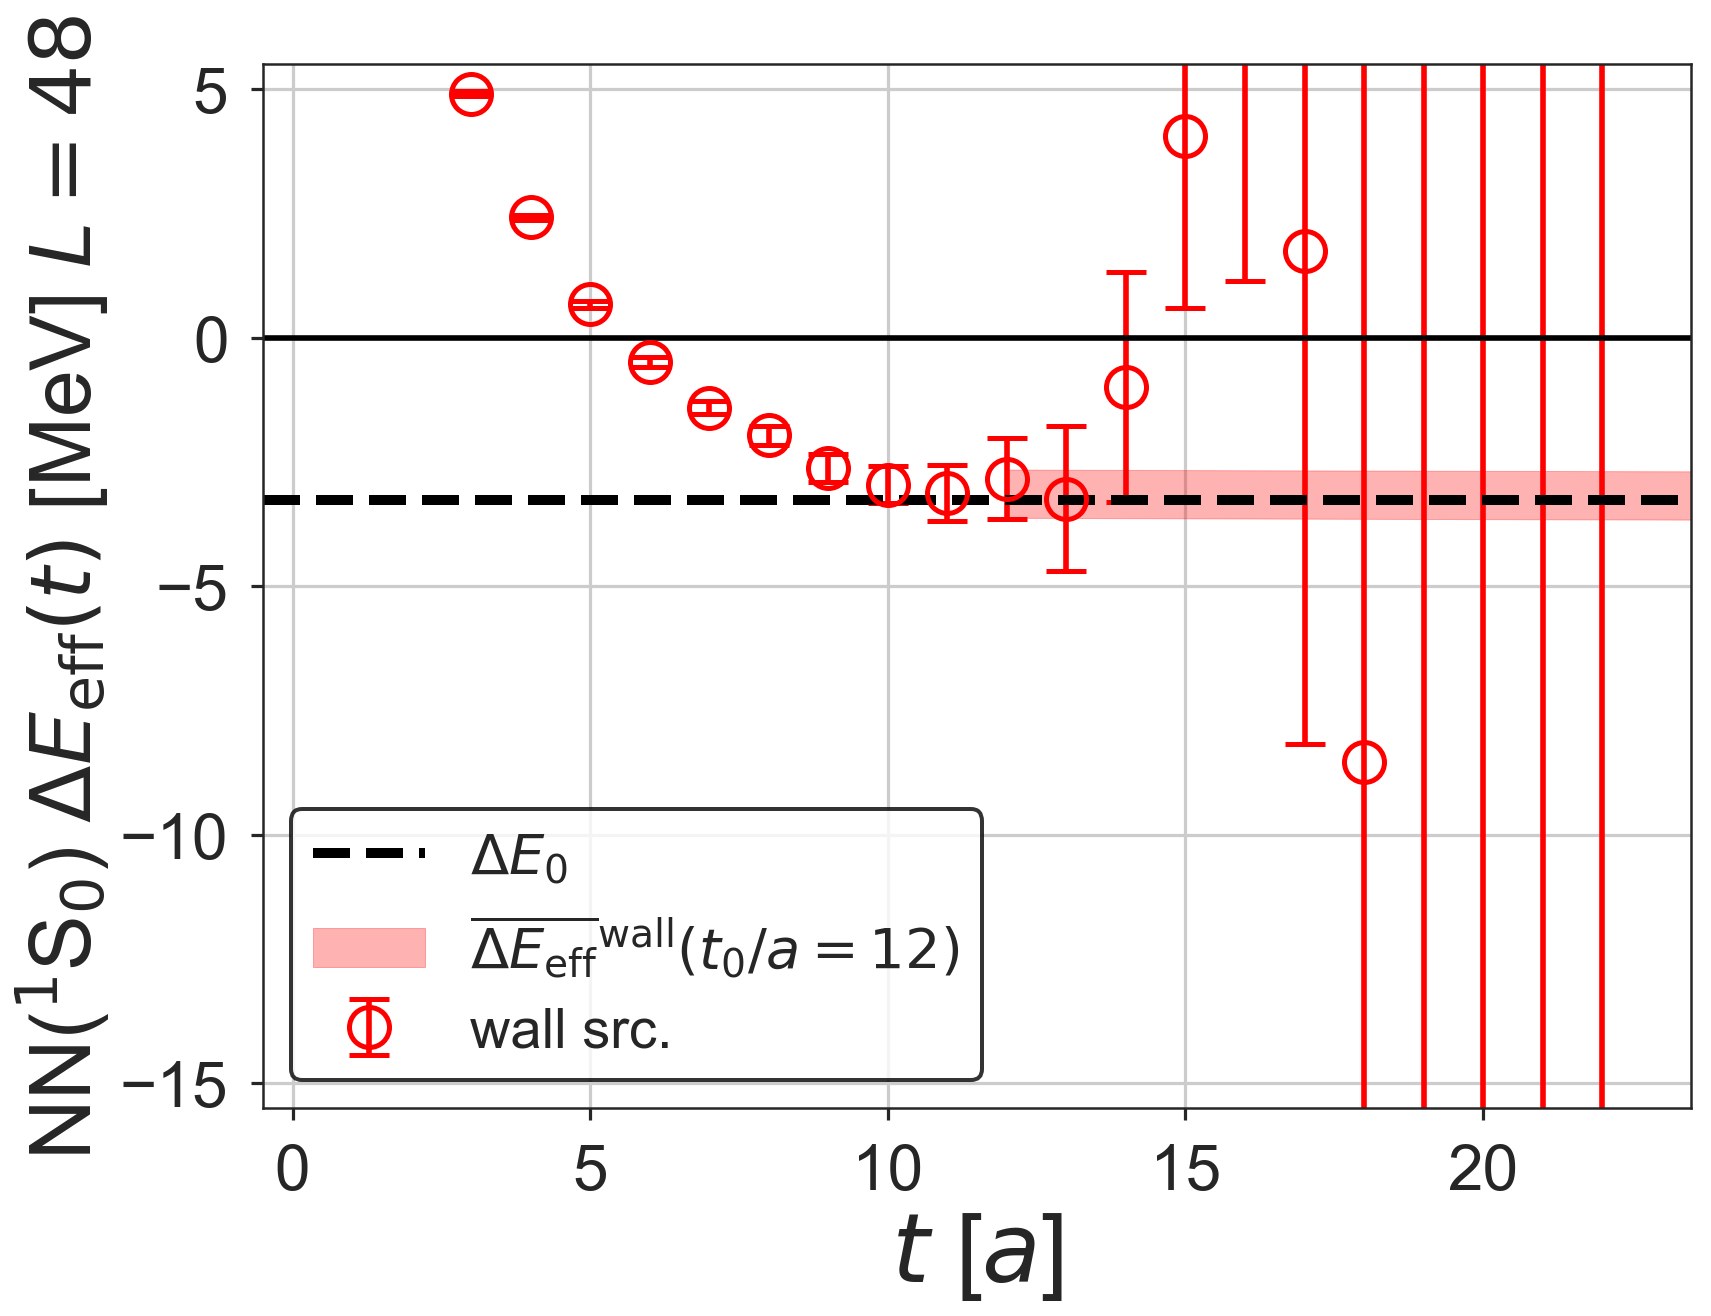

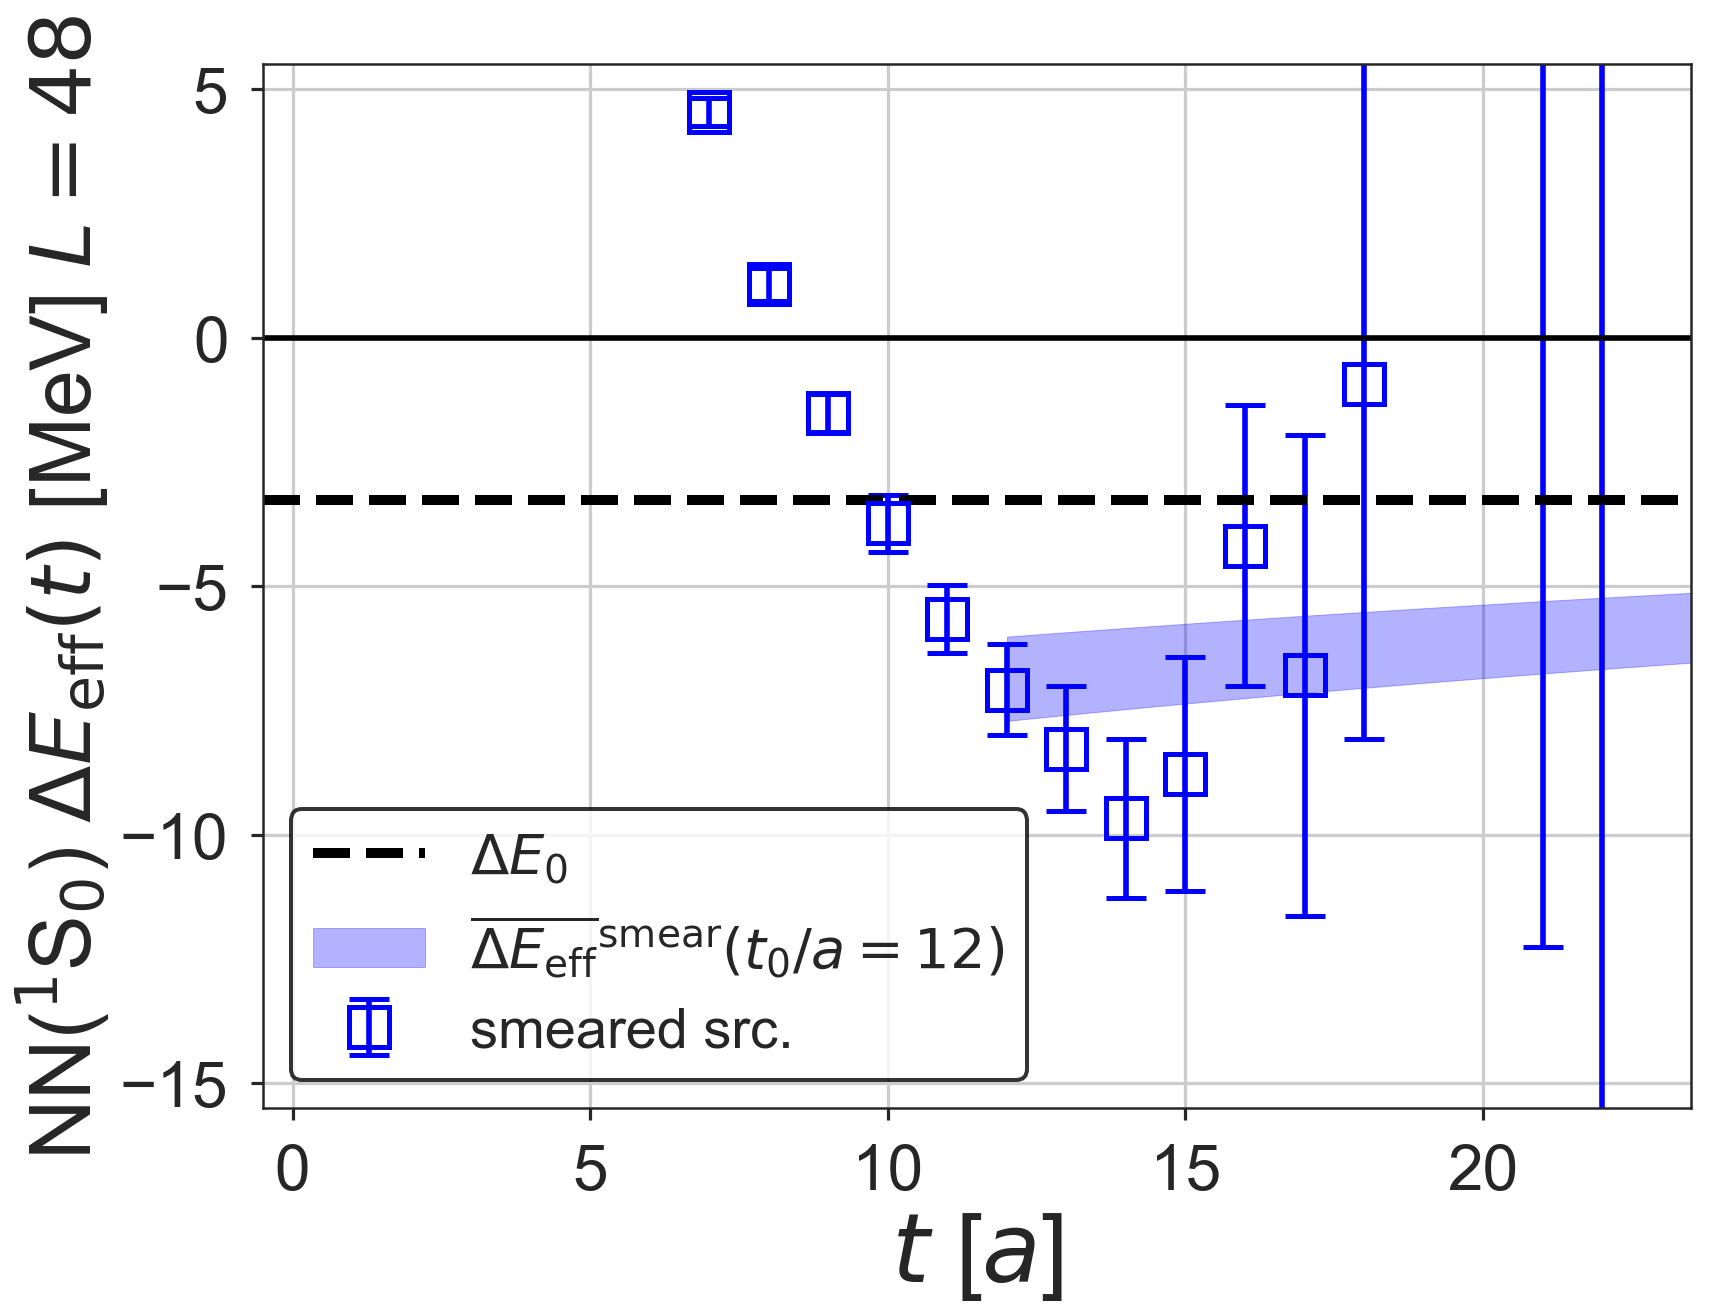

In [37]:
def plot_dEeff_with_ReEeff_src(src0):
    fig, ax = plt.subplots()
    if src0 == 'wall':
        ax.errorbar(dEeffs['wall'][:,0], dEeffs['wall'][:,3]*ainv, dEeffs['wall'][:,4]*ainv,
                fmt='o', color='red', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='red', ms=20, label=rf'wall src.')
    elif src0 == 'exp':
        ax.errorbar(dEeffs['exp'][:,0], dEeffs['exp'][:,3]*ainv, dEeffs['exp'][:,4]*ainv,
                fmt='s', color='blue', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='blue', ms=20, label=rf'smeared src.')

    its = np.linspace(it0, 24)
    for src, color in zip(['wall', 'exp'], ['red', 'blue']):
        if not src == src0: continue
        ReEeff = calc_ReEeff(src, its)
        ax.fill_between(its, (ReEeff[:,0] + ReEeff[:,1])*ainv,
                       (ReEeff[:,0] - ReEeff[:,1])*ainv, color=color, alpha=0.3,
                       label=r'$\overline{{\Delta E_\mathrm{{eff}}}}^\mathrm{{{}}}(t_0/a = {})$'.format({'wall':'wall','exp':'smear'}[src],
                                                                                                       it0))  
        
    ax.axhline(vals[:,0].mean()*ainv, linestyle='--', color='black', lw=5,
              label=r'$\Delta E_0$'.format(it0))
    ax.axhline(0, color='black')
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(loc='lower left', frameon=True, fontsize=28)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'NN($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
    fig.savefig(f'../figs/nn_1s0_REdEeff_{src0}_{L}.pdf', bbox_inches='tight')

for src in ['wall', 'exp']:
    plot_dEeff_with_ReEeff_src(src)

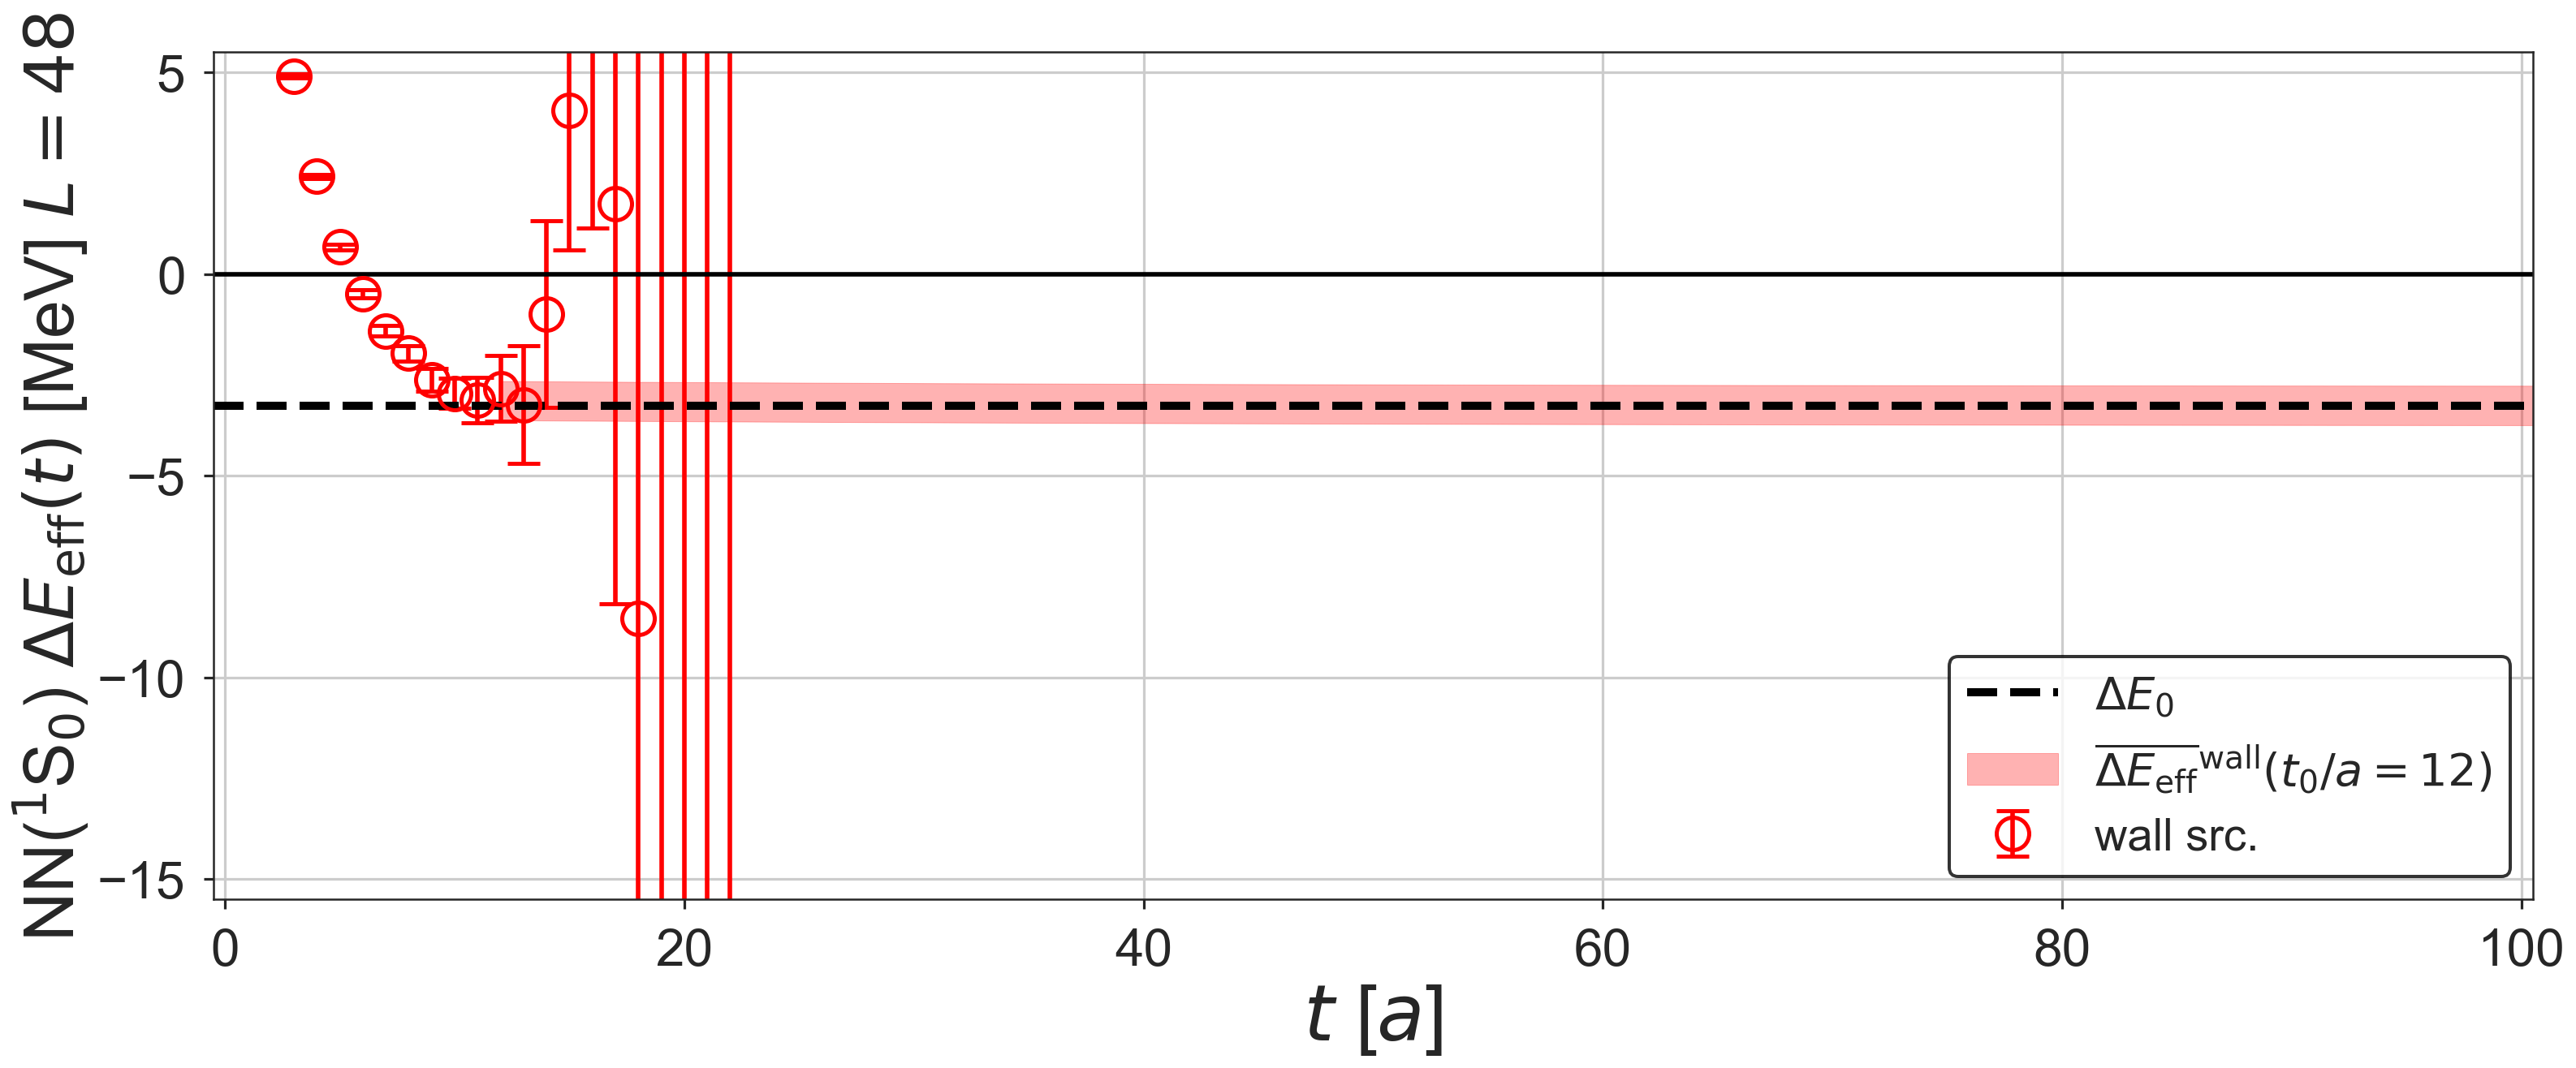

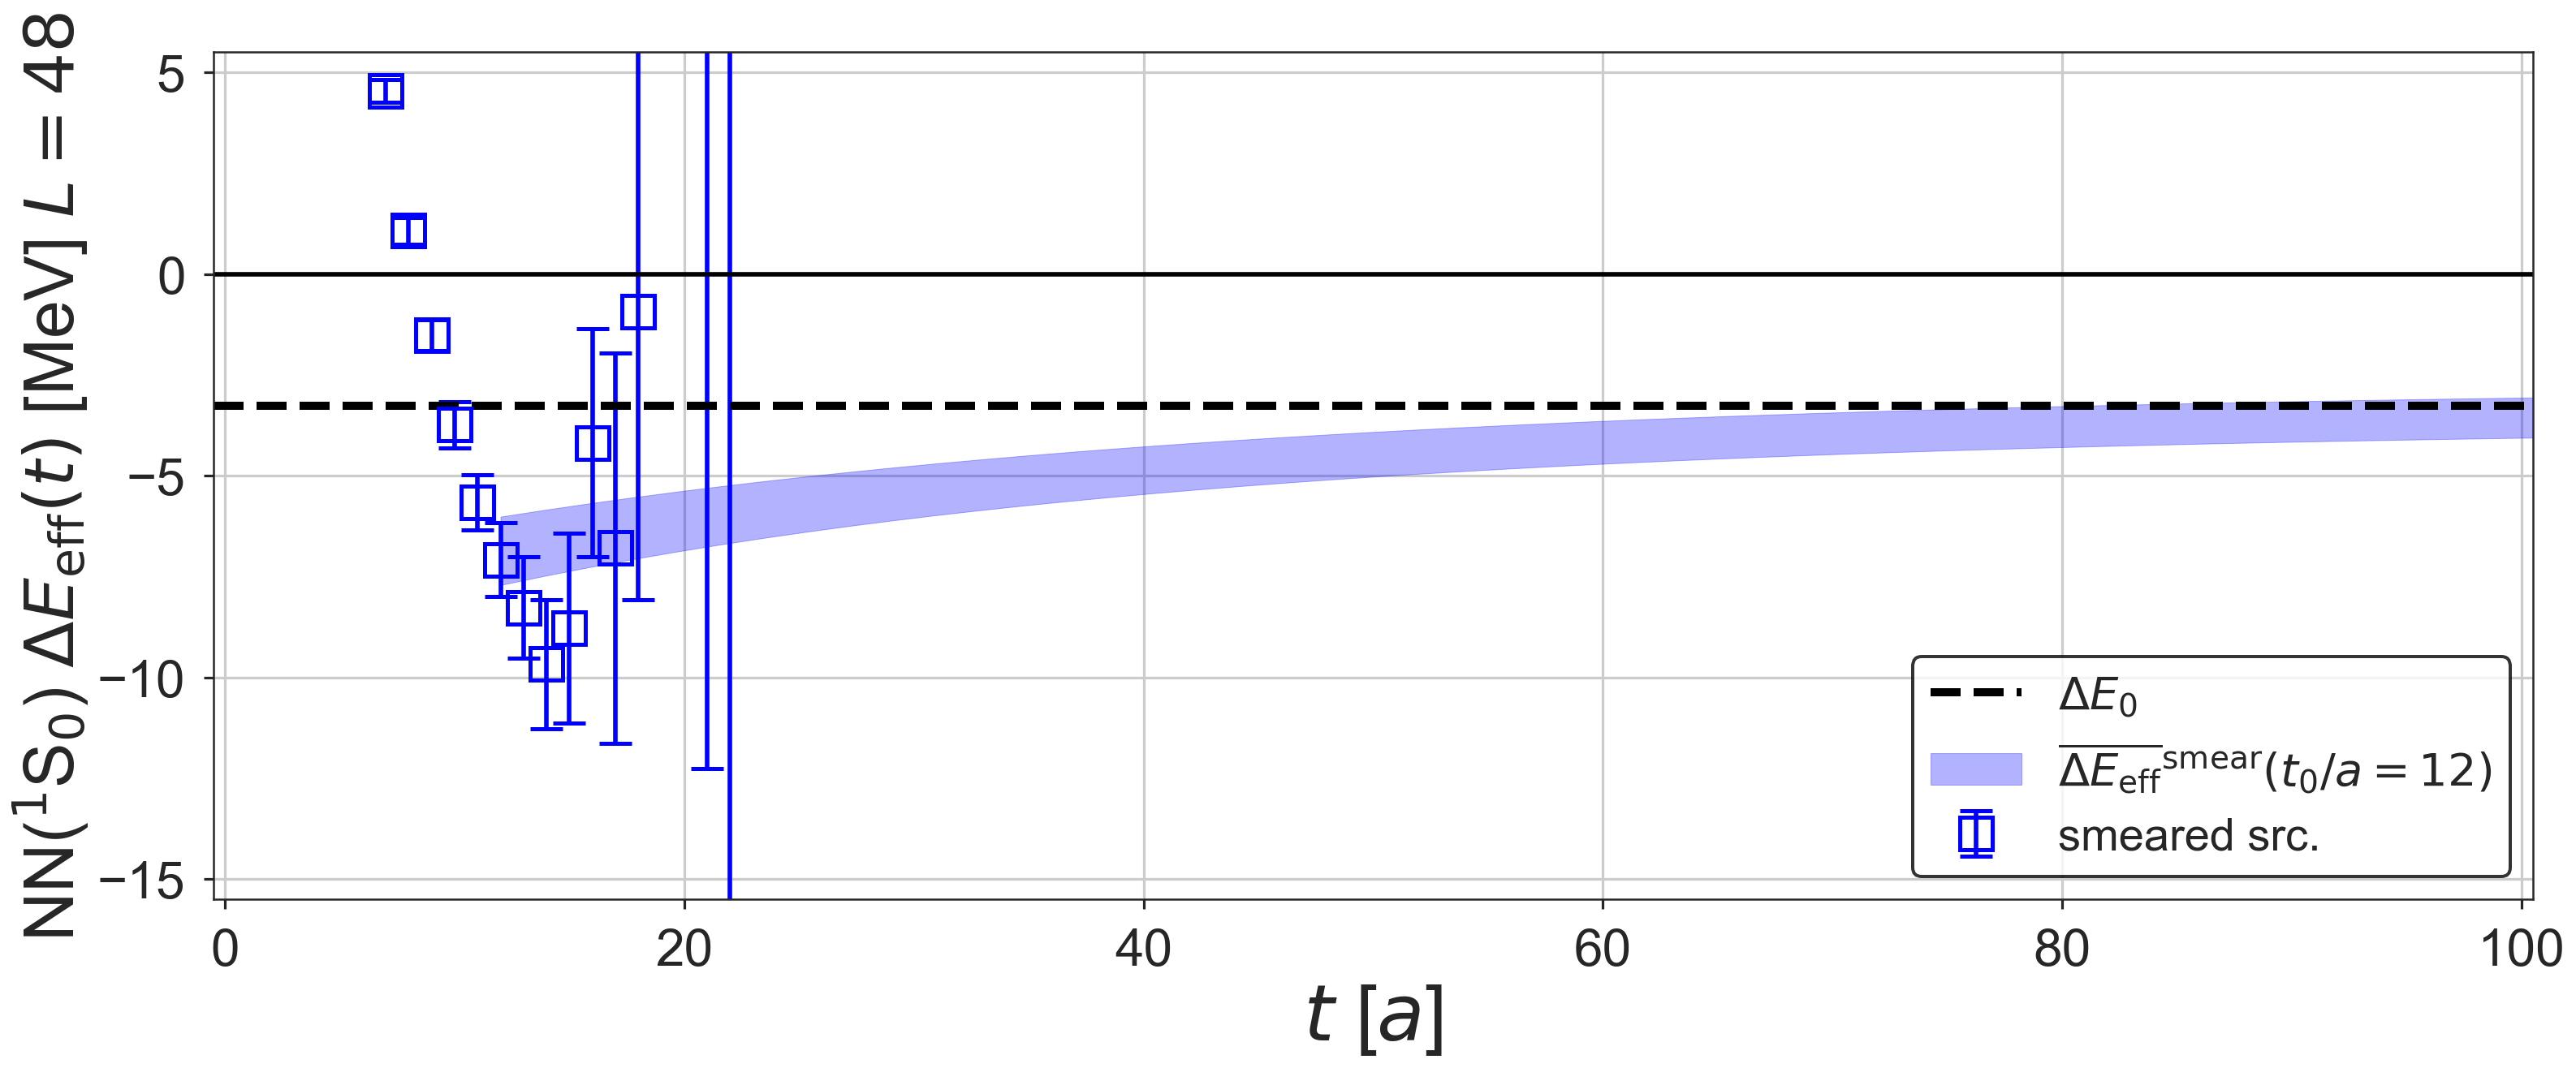

In [38]:
def plot_dEeff_with_ReEeff_src_asymptotic(src0):
    fig, ax = plt.subplots(figsize=(12.8*2, 9.6))
    if src0 == 'wall':
        ax.errorbar(dEeffs['wall'][:,0], dEeffs['wall'][:,3]*ainv, dEeffs['wall'][:,4]*ainv,
                fmt='o', color='red', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='red', ms=20, label=rf'wall src.')
    elif src0 == 'exp':
        ax.errorbar(dEeffs['exp'][:,0], dEeffs['exp'][:,3]*ainv, dEeffs['exp'][:,4]*ainv,
                fmt='s', color='blue', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='blue', ms=20, label=rf'smeared src.')

    its = np.linspace(it0, 105)
    for src, color in zip(['wall', 'exp'], ['red', 'blue']):
        if not src == src0: continue
        ReEeff = calc_ReEeff(src, its)
        ax.fill_between(its, (ReEeff[:,0] + ReEeff[:,1])*ainv,
                       (ReEeff[:,0] - ReEeff[:,1])*ainv, color=color, alpha=0.3,
                       label=r'$\overline{{\Delta E_\mathrm{{eff}}}}^\mathrm{{{}}}(t_0/a = {})$'.format({'wall':'wall','exp':'smear'}[src],
                                                                                                       it0))  
        
    ax.axhline(vals[:,0].mean()*ainv, linestyle='--', color='black', lw=5,
              label=r'$\Delta E_0$'.format(it0))
    ax.axhline(0, color='black')
    ax.set_xlim(-0.5, 100.5)
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(loc='lower right', frameon=True, fontsize=28)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'NN($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
    fig.savefig(f'../figs/nn_1s0_REdEeff_{src0}_{L}_asymptotic.pdf', bbox_inches='tight')

for src in ['wall', 'exp']:
    plot_dEeff_with_ReEeff_src_asymptotic(src)

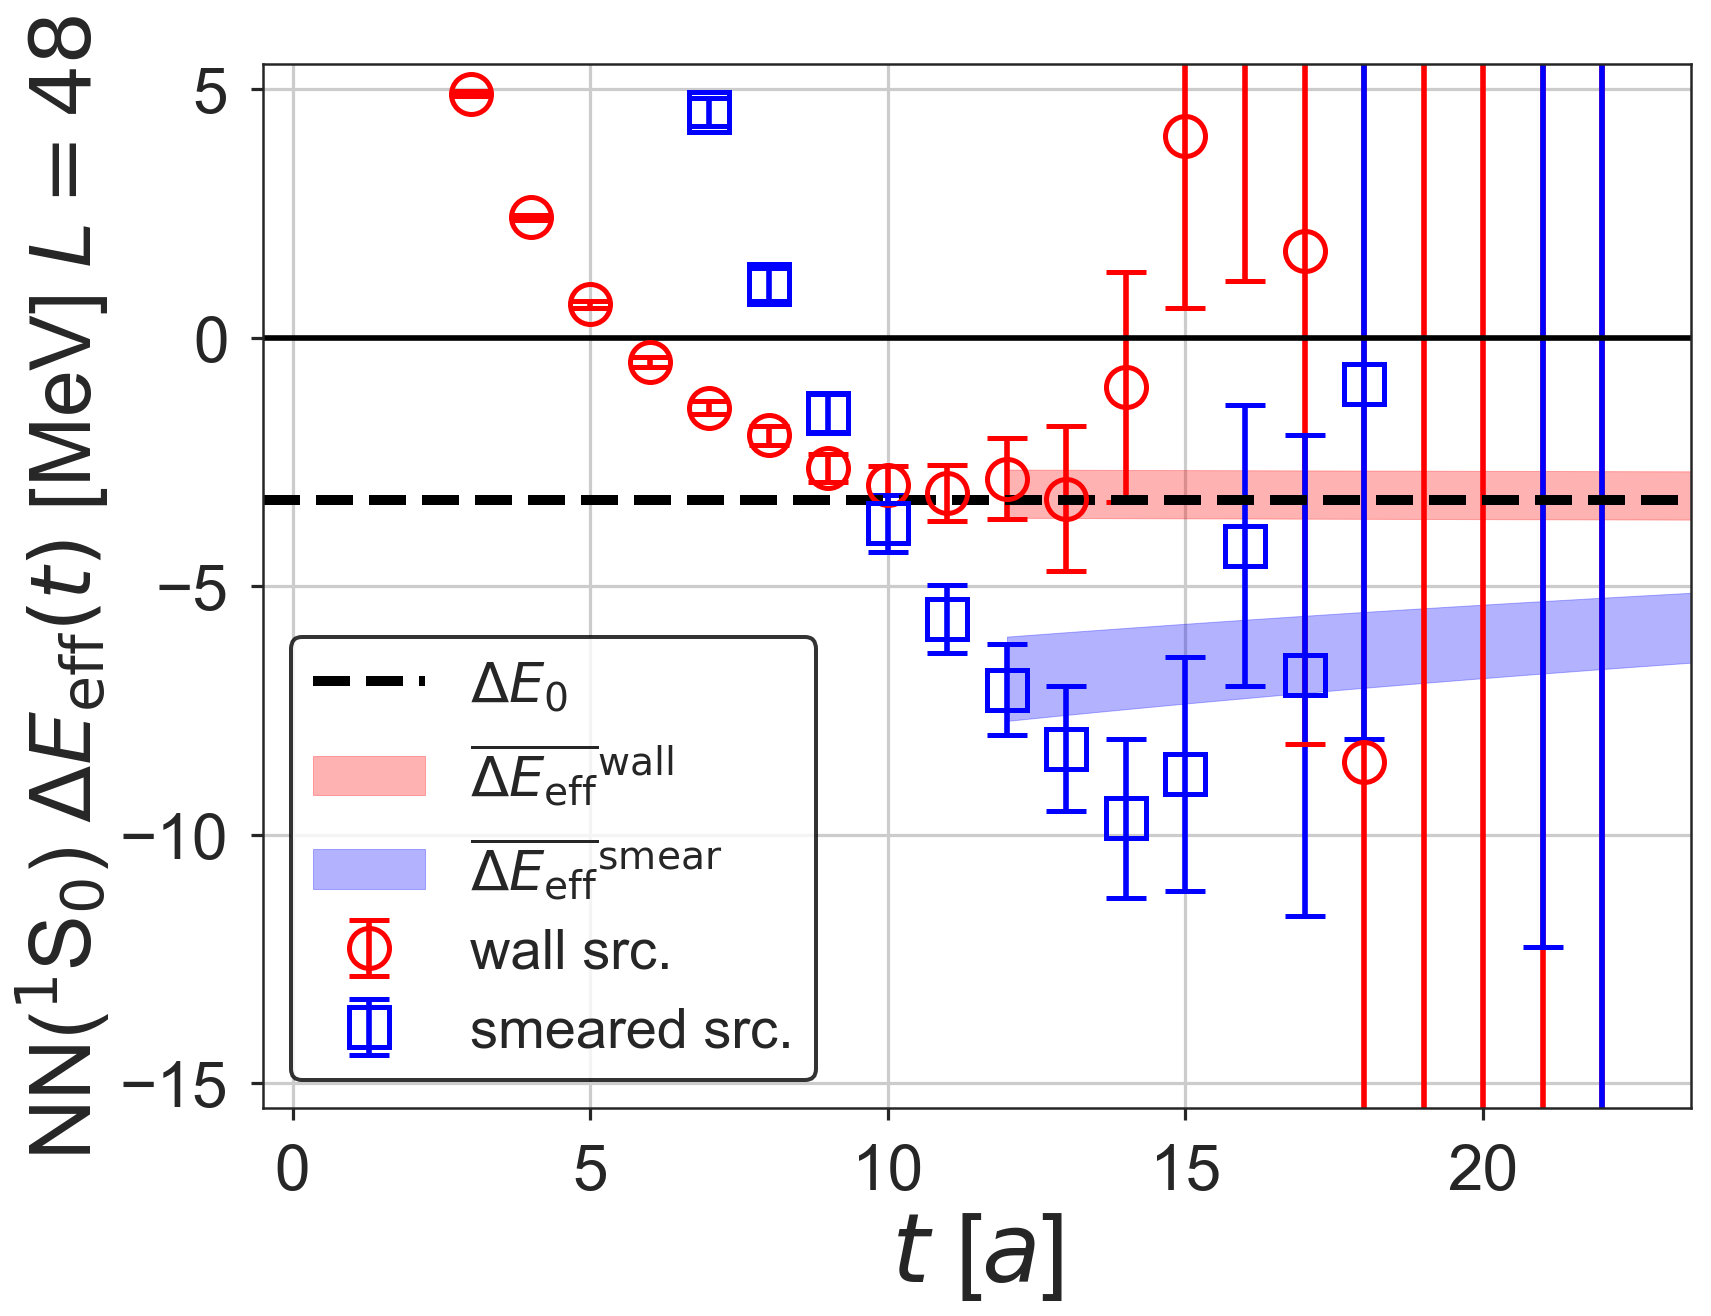

In [39]:
def plot_dEeff_with_ReEeff():
    fig, ax = plt.subplots()
    ax.errorbar(dEeffs['wall'][:,0], dEeffs['wall'][:,3]*ainv, dEeffs['wall'][:,4]*ainv,
                fmt='o', color='red', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='red', ms=20, label=rf'wall src.')
    ax.errorbar(dEeffs['exp'][:,0], dEeffs['exp'][:,3]*ainv, dEeffs['exp'][:,4]*ainv,
                fmt='s', color='blue', mfc='none', capsize=10, capthick=2.0, mew=2.5, mec='blue', ms=20, label=rf'smeared src.')

    its = np.linspace(it0, 24)
    for src, color in zip(['wall', 'exp'], ['red', 'blue']):
        ReEeff = calc_ReEeff(src, its)
        ax.fill_between(its, (ReEeff[:,0] + ReEeff[:,1])*ainv,
                       (ReEeff[:,0] - ReEeff[:,1])*ainv, color=color, alpha=0.3,
                       label=r'$\overline{{\Delta E_\mathrm{{eff}}}}^\mathrm{{{}}}$'.format({'wall':'wall','exp':'smear'}[src]))
                                                                                  
        
    ax.axhline(vals[:,0].mean()*ainv, linestyle='--', color='black', lw=5,
              label=r'$\Delta E_0$'.format(it0))
    ax.axhline(0, color='black')
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(-15.5, 5.5)
    ax.set_yticks([-15, -10, -5, 0, 5])
    leg = ax.legend(loc='lower left', frameon=True, fontsize=28)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')

    ax.set_xlabel(r'$t$ [$a$]', fontsize=48)
    ax.set_ylabel(rf'NN($^1$S$_0$) $\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {L}$', fontsize=42)
    fig.savefig(f'../figs/nn_1s0_REdEeff_{L}.pdf', bbox_inches='tight')

plot_dEeff_with_ReEeff()